# The Quantum Phase Estimation Algorithm

In this tutorial, you will run the Quantum Phase Estimation algorithm using the Sampler primitive Qiskit Runtime program.

## Set up your local development environment

This tutorial requires a Qiskit Runtime service instance. If you haven't done so already, please follow the [Getting Started Guide](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/getting_started.html) to set one up.

## Background information

### Quantum phase estimation

Quantum phase estimation is one of the most important subroutines in quantum computation. It serves as a central building block for many quantum algorithms. The objective of the algorithm is the following:

Given a unitary operator $U$, the algorithm estimates $\theta$ in $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$. Here $|\psi\rangle$ is an eigenvector and $e^{\boldsymbol{2\pi i}\theta}$ is the corresponding eigenvalue. Since $U$ is unitary, all of its eigenvalues have a norm of 1.

If you want to learn more, you can read the chapter about quantum phase estimation in [the Qiskit textbook](https://learn.qiskit.org/course/ch-algorithms/quantum-phase-estimation).

## Step 1: Create QPE circuits and bind parameters to the circuits

### Create QPE circuits

In [15]:
import math
import numpy as np

from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT


def make_qpe_circuit(eigenvalue, bits):

    def unitary_eff(eigenvalue):

        unitary = [-2*eigenvalue, -np.pi/2, np.pi/2]

        return unitary
    
    def controlled_unitary(unitary, control, target, circuit):
        circuit.p((unitary[2]-unitary[1])/2, target)
        circuit.cx(control, target)
        circuit.u(-unitary[0]/2,0,-(unitary[2]+unitary[1])/2, target)
        circuit.cx(control, target)
        circuit.u(unitary[0]/2,unitary[1],0, target)
        return circuit

    # Create a quantum circuit with `bits+1` bits of qubits in a quantum register
    # and `bits` bits of clbits in a classical register
    qc = QuantumCircuit(bits+1, bits)

    qc.h(bits)


    # Apply controlled-unitaries, conditional rotations, and measure in the X-basis
    for nind in range(bits):
        k = bits-nind

        #First, prepare ancilla in |+>
        qc.h(nind)

        #Now, apply sequence of 2**(k-1) controlled-unitary
        controlled_unitary(unitary_eff(eigenvalue*(2**(k-1))), nind, bits, qc)

    qc.barrier()
    qc = qc.compose(QFT(bits, inverse=True), list(range(bits)))

    qc.barrier()
    qc.measure(range(bits), range(bits))

    return qc

### Bind parameters to QPE circuits

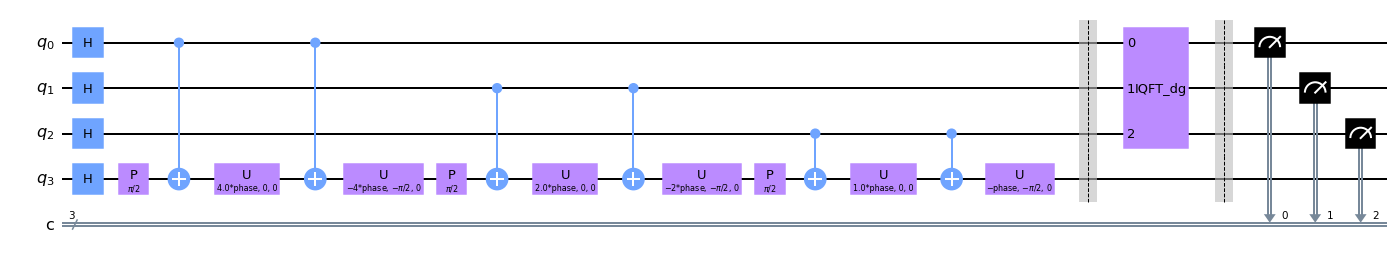

In [16]:
from qiskit.circuit import Parameter

phase = Parameter('phase')

qpe_circuits = make_qpe_circuit(phase, 3)
qpe_circuits.draw('mpl',fold=-1)

In [3]:
number_of_phases = 80
phases = np.linspace(0, 4*np.pi, number_of_phases)
# Phases need to be expressed as list of lists
individual_phases = [[ph] for ph in phases]

## Step 2: Submit the circuits to a quantum computer on the cloud

### Connect to the Qiskit Runtime service 

First, connect to the Qiskit Runtime service instance that you created in [the first step](#Set-up-your-local-development-environment).

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
options = {'backend_name': 'ibmq_qasm_simulator'}  # use the simulator

### Run the circuits using the Sampler primitive

In [5]:
from qiskit_ibm_runtime import Sampler

with Sampler(circuits=qpe_circuits, service=service, options=options) as sampler:
    param_results = sampler(circuits=[0]*len(phases), parameter_values=individual_phases)

## Step 3: Analyze results

In [6]:
def evaluate_wrap(phase, phi):
    # Choose whether to wrap or not. Phase is the problem phase. Phi is the computation output.
    if np.abs(wrapAngle(phi) - phase/(2*np.pi)) < np.abs(phi - phase/(2*(np.pi))):
        return wrapAngle(phi)
    else:
        return phi
    
def output_to_phi(bitstring):
    bin_exp = 0
    for ind, stringbit in enumerate(bitstring):
        bin_exp += int(stringbit)/2**(ind+1)
    return bin_exp

def wrapAngle(phase):
    # This function maps the interval \varphi \in [0,1] into [-0.5, 0.5], where the sub-inverval [0.5,1] moves into [-0.5,0] and the interval [0,0.5] remains untouched
    # phases between pi and 2pi become negative.
    phase_wrapped = ((phase*2*np.pi + np.pi) % (2 * np.pi) - np.pi)/(2*np.pi)
    return phase_wrapped

def most_likely_bitstring(dictionary):
    return max(dictionary, key=dictionary.get)

In [7]:
def most_likely_bits(dictionary, phi):

    # Return the IPE result if one looks at the most likely outcome and if one looks at the two most likely
    # outcomes.
    val = list(dictionary.values())
    val.sort()
    counts_left = 0
    counts_right = 0
    most_likely_counts = val[-1]

    # First we compute the second most likely key without enforcing neighborhood:

    if len(dictionary) > 1:

        second_most_likely_counts = val[-2]

    else:

        second_most_likely_counts = most_likely_counts

    for key, value in dictionary.items():

        if value == most_likely_counts:

            most_likely_key = key

        if value == second_most_likely_counts:

            if len(dictionary) > 1 and val[-2] == val[-1]:

                second_most_likely_key = [key for key, value in dictionary.items() if value == val[-2] and key != most_likely_key]
                second_most_likely_key = second_most_likely_key[0]
            else:
                second_most_likely_key = key


    neighbor_left = len(most_likely_key)*'1' if most_likely_key == len(most_likely_key)*'0' else format((int(most_likely_key,2)-1), '0%sb'%len(most_likely_key))
    neighbor_right = len(most_likely_key)*'0' if most_likely_key == len(most_likely_key)*'1' else format((int(most_likely_key,2)+1), '0%sb'%len(most_likely_key))

    if len(dictionary) > 1:

        # First check if neighbor keys exist

        if neighbor_left in dictionary.keys():

            counts_left = dictionary[neighbor_left]

        if neighbor_right in dictionary.keys():

            counts_right = dictionary[neighbor_right]

    else:

        second_most_likely_neighbor_key = most_likely_key
        second_most_likely_neighbor_counts = most_likely_counts

    if counts_left == 0 and counts_right == 0:

        second_most_likely_neighbor_key = most_likely_key
        second_most_likely_neighbor_counts = most_likely_counts

    else:

        if counts_left > counts_right:

            second_most_likely_neighbor_key = neighbor_left
            second_most_likely_neighbor_counts = counts_left

        else:

            second_most_likely_neighbor_key = neighbor_right
            second_most_likely_neighbor_counts = counts_right


    # Here we have a dictionary with the outcomes, the two most likely bitstrings and their counts.
    # We want to return the most likely bitstring and an average of the counts of the two most
    # likely bitstrings

    most_likely_bit_phase = evaluate_wrap(2*np.pi*phi, output_to_phi(most_likely_key))
    second_most_likely_neighbor_bit_phase = evaluate_wrap(2*np.pi*phi,output_to_phi(second_most_likely_neighbor_key))
    second_most_likely_bit_phase = evaluate_wrap(2*np.pi*phi, output_to_phi(second_most_likely_key))


    # Now average both second most likely keys.
#     numer = (most_likely_counts*most_likely_bit_phase + second_most_likely_counts*second_most_likely_bit_phase)
#     denom = (most_likely_counts+second_most_likely_counts)
#     two_most_likely_bits_phase = numer/denom

    numer = (most_likely_counts*most_likely_bit_phase + second_most_likely_neighbor_counts*second_most_likely_neighbor_bit_phase)
    denom = (most_likely_counts+second_most_likely_neighbor_counts)
    two_most_likely_neighbor_bits_phase = numer/denom

    return two_most_likely_neighbor_bits_phase

In [8]:
qpe_solution = []
for idx, results in enumerate(param_results.quasi_dists):
    solution = most_likely_bitstring(results)
    phase = evaluate_wrap(phases[idx], output_to_phi(solution))
#     phase = output_to_phi(solution)
    qpe_solution.append(2*np.pi*phase)

In [9]:
qpe_solution = []
for idx, results in enumerate(param_results.quasi_dists):
    solution = most_likely_bits(results, phases[idx]/(2*np.pi))
    qpe_solution.append(2*np.pi*solution)

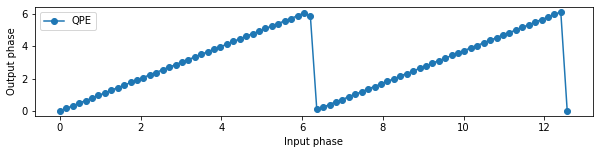

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 2))

# ax1 = fig.add_axes([0, 0, 1, 1])

plt.plot(phases, qpe_solution, 'o-', label='QPE')
# plt.plot(phases, chsh2_sim, 'o-', label='CHSH2 Noiseless')
# plt.plot(phases, chsh1_exp, 'o-', label='CHSH1 Kolkata')
# plt.plot(phases, chsh2_exp, 'o-', label='CHSH2 Kolkata')
# plt.axhline(y=2, color='r', linestyle='-')
# plt.axhline(y=-2, color='r', linestyle='-')
# plt.axhline(y=np.sqrt(2)*2, color='b', linestyle='-.')
# plt.axhline(y=-np.sqrt(2)*2, color='b', linestyle='-.')
plt.xlabel('Input phase')
plt.ylabel('Output phase')
plt.legend()